# Analyzing the Mojito Album Cover using `fasterrcnn`

> 麻烦给我的爱人来一杯 Mojito 🎵🎵🎵

This notebook demonstrates how to use Liga Vision to analyze the Mojito album cover.

In [ ]:
# For Python Environment without `liga-tv`, eg. Google Colab
!pip install liga-tv

In [1]:
from ligavision.dsl import conf
conf.image.notebook = "github"

## Image Visualization

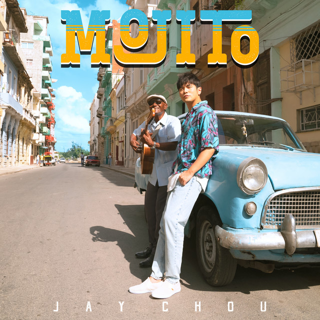

In [2]:
from ligavision.spark.types import Image
uri = 'https://i.scdn.co/image/ab67616d0000b273466def3ce70d94dcacb13c8d'
image = Image(uri)
image * 0.5

## Initialization
+ Initialize the Spark Session with Rikai support
+ Register all built-in UDFs
+ Create the yolov5m model

In [3]:
from ligavision.spark import init_session

spark = init_session()

2023-02-17 16:03:23,213 INFO Rikai (__init__.py:127): setting spark.sql.extensions to net.xmacs.liga.spark.RikaiSparkSessionExtensions,org.apache.spark.sql.rikai.LigaImageExtensions
2023-02-17 16:03:23,214 INFO Rikai (__init__.py:127): setting spark.driver.extraJavaOptions to -Dio.netty.tryReflectionSetAccessible=true
2023-02-17 16:03:23,214 INFO Rikai (__init__.py:127): setting spark.executor.extraJavaOptions to -Dio.netty.tryReflectionSetAccessible=true
2023-02-17 16:03:23,215 INFO Rikai (__init__.py:127): setting spark.jars to https://github.com/liga-ai/ligavision/releases/download/ligavision_0.2.0/liga-image-assembly_2.12-0.2.0.jar
23/02/17 16:03:24 WARN Utils: Your hostname, tubi resolves to a loopback address: 127.0.1.1; using 192.168.31.30 instead (on interface wlp0s20f3)
23/02/17 16:03:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To ad

In [4]:
model = "fasterrcnn"
spark.sql(f"""
CREATE MODEL {model}
USING pytorch
MODEL_TYPE {model}
""")

DataFrame[]

In [5]:
spark.sql(f"""
select pred.box, pred.label, pred.score
from (
  select explode(ML_PREDICT({model}, image('{uri}'))) as pred
)
""").toPandas()

/home/da/.cache/pants/named_caches/pex_root/venvs/d44d4dd571248e4aec9224fd2cac0d3ffa6602a1/52b202b40c27ebbac3262ecc98ac040dc7b49cb8/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/da/.cache/pants/named_caches/pex_root/venvs/d44d4dd571248e4aec9224fd2cac0d3ffa6602a1/52b202b40c27ebbac3262ecc98ac040dc7b49cb8/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


,box,label,score
0,"(260.8822937011719, 185.93405151367188, 362.79...",person,0.998171
1,"(251.2159881591797, 158.17874145507812, 434.39...",person,0.987624
2,"(118.61577606201172, 315.0271911621094, 130.44...",car,0.976575
3,"(167.56834411621094, 311.38079833984375, 199.6...",car,0.973258
4,"(274.18463134765625, 215.0655517578125, 637.30...",car,0.854007
5,"(102.44403076171875, 320.8999938964844, 112.73...",car,0.705664
6,"(214.35220336914062, 305.7699890136719, 223.90...",person,0.540603


## Q: How many cars/persons in this picture

In [6]:
df = spark.sql(f"""
select pred.label, count(*)
from (
  select *, explode(ML_PREDICT({model}, image)) as pred
  from (
    select image('{uri}') as image
  )
)
group by pred.label
""")
df.toPandas()

,label,count(1)
0,person,3
1,car,4


## Q2: Where are these cars and persons?

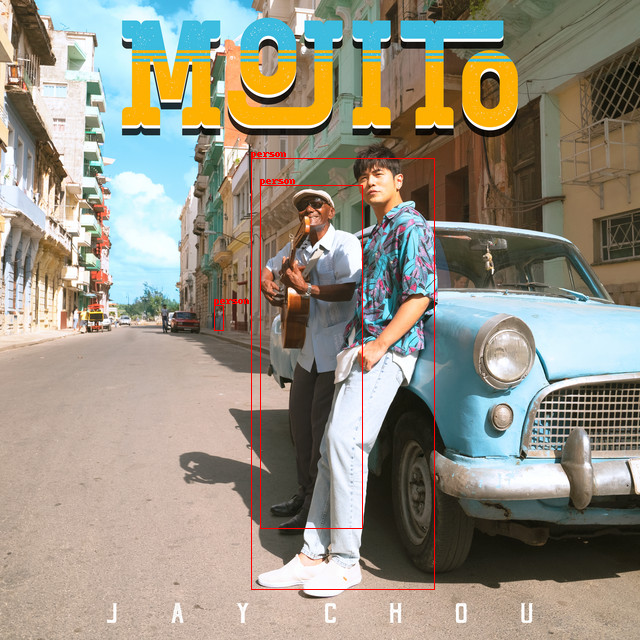

In [7]:
from ligavision.dsl import Text
from ligavision.dsl import Image
from functools import reduce

df = spark.sql(f"""
select * from (
  select explode(ML_PREDICT({model}, image)) as pred
  from (
    select image('{uri}') as image
  )
)
where pred.label = 'person' -- truck/car/person
""")
preds = [row.pred for row in df.collect()]

def add_layer(image, pred):
    return image | pred.box | Text(pred.label, (pred.box.xmin, pred.box.ymin - 10))

reduce(lambda a,b: add_layer(a, b), [image] + preds)